# 1.8h: The Grid

The 4 black holes differ in only 10 dimensions out of 2,560. Within those 10 dimensions, they differ by small integer steps in mantissa space.

**Goal:** Visualize the discrete lattice structure by plotting mantissa values (integers 0-127) for each active dimension.

This shows the true geometric shape: not a smooth hypercube, but a discrete grid where the 4 points occupy specific lattice sites separated by 1-4 mantissa steps.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Dimensions to analyze (from 1.8f/1.8g)
DIMENSIONS_TO_ANALYZE = [216, 282, 322, 1008, 1272, 1382, 1487, 1564, 2040, 2079]

# Basis dimensions (from 1.8a)
MERIDIAN_IDX = 322  # x
EQUINOX_IDX = 1564  # y
NORTH_IDX = 163     # z

## Imports

In [2]:
import torch
import ml_dtypes
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Helper Functions

In [3]:
def decode_bfloat16_bits(value_bf16):
    """
    Decode a bfloat16 value into its bit components.
    """
    # Convert to uint16 to get raw bits
    bits_uint16 = np.frombuffer(value_bf16.tobytes(), dtype=np.uint16)[0]
    
    # Format as 16-bit binary string
    bits_binary = format(bits_uint16, '016b')
    
    # Extract components
    sign_bit = bits_binary[0]
    exponent_bits = bits_binary[1:9]
    mantissa_bits = bits_binary[9:16]
    
    # Decode values
    sign = int(sign_bit)
    exponent = int(exponent_bits, 2)
    mantissa = int(mantissa_bits, 2)
    
    return {
        'bits_uint16': bits_uint16,
        'bits_binary': bits_binary,
        'sign': sign,
        'exponent': exponent,
        'mantissa': mantissa,
        'sign_bit': sign_bit,
        'exponent_bits': exponent_bits,
        'mantissa_bits': mantissa_bits
    }

def compute_ulp_from_exponent(exponent):
    """
    Compute ULP (unit in last place) for a given bfloat16 exponent.
    ULP = 2^(exponent - 127 - 7)
    The -7 comes from the 7 mantissa bits.
    """
    return 2.0 ** (exponent - 127 - 7)

## Device Detection

In [4]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [5]:
# Load W in bfloat16 (uncentered, original bits)
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")

Loaded W: torch.Size([151936, 2560])


In [6]:
# Load black hole data
bh_path = Path(f"../tensors/{MODEL_NAME}/1.8e_black_hole_masks.safetensors")
bh_data = load_file(bh_path)

bh1_token_ids = bh_data["bh1_token_ids"].to(torch.int64)
bh2_token_ids = bh_data["bh2_token_ids"].to(torch.int64)
bh3_token_ids = bh_data["bh3_token_ids"].to(torch.int64)
bh4_token_ids = bh_data["bh4_token_ids"].to(torch.int64)

print(f"\nLoaded black holes:")
print(f"  BH1: {len(bh1_token_ids):,} tokens")
print(f"  BH2: {len(bh2_token_ids):,} tokens")
print(f"  BH3: {len(bh3_token_ids):,} tokens")
print(f"  BH4: {len(bh4_token_ids):,} tokens")


Loaded black holes:
  BH1: 866 tokens
  BH2: 734 tokens
  BH3: 329 tokens
  BH4: 249 tokens


## Extract Black Hole Representative Vectors

In [7]:
print("\nExtracting black hole representative vectors...\n")

# Get first token from each black hole as representative
bh_token_ids = [
    bh1_token_ids[0].item(),
    bh2_token_ids[0].item(),
    bh3_token_ids[0].item(),
    bh4_token_ids[0].item()
]

# Get ORIGINAL vectors from W (not centered!)
bh_vectors_bf16 = []
for i, token_id in enumerate(bh_token_ids, 1):
    vector = W_bf16[token_id]
    bh_vectors_bf16.append(vector)
    print(f"BH{i}: Token {token_id}")

print(f"\n✓ Extracted {len(bh_vectors_bf16)} representative vectors")


Extracting black hole representative vectors...

BH1: Token 80091
BH2: Token 125
BH3: Token 124
BH4: Token 123939

✓ Extracted 4 representative vectors


## Extract Mantissa Values for Each Dimension

In [8]:
print("\nExtracting mantissa values...\n")

# For each dimension, collect mantissa values and exponent
grid_data = []

for dim in DIMENSIONS_TO_ANALYZE:
    # Extract values for this dimension
    values_bf16 = []
    for bh_vec in bh_vectors_bf16:
        val = bh_vec[dim].cpu().view(torch.uint16).item()
        val_bf16 = np.frombuffer(np.uint16(val).tobytes(), dtype=ml_dtypes.bfloat16)[0]
        values_bf16.append(val_bf16)
    
    # Decode bit patterns
    decoded = [decode_bfloat16_bits(v) for v in values_bf16]
    
    # Extract mantissas and exponents
    mantissas = [d['mantissa'] for d in decoded]
    exponents = [d['exponent'] for d in decoded]
    signs = [d['sign'] for d in decoded]
    
    # Check if all have same exponent (should be true)
    unique_exponents = set(exponents)
    if len(unique_exponents) != 1:
        print(f"WARNING: Dimension {dim} has multiple exponents: {unique_exponents}")
    
    exponent = exponents[0]
    sign = signs[0]  # Assume all same sign
    ulp = compute_ulp_from_exponent(exponent)
    
    # Store data
    grid_data.append({
        'dim': dim,
        'mantissas': mantissas,
        'exponent': exponent,
        'sign': sign,
        'ulp': ulp,
        'is_basis': dim in [MERIDIAN_IDX, EQUINOX_IDX, NORTH_IDX]
    })
    
    basis_marker = " (BASIS)" if dim in [MERIDIAN_IDX, EQUINOX_IDX, NORTH_IDX] else ""
    sign_str = "-" if sign == 1 else "+"
    span = max(mantissas) - min(mantissas)
    print(f"Dimension {dim:4d}{basis_marker}: exp={exponent:3d}, mantissas={mantissas}, span={span}, ULP={ulp:.2e} {sign_str}")

print(f"\n✓ Extracted mantissa values for {len(grid_data)} dimensions")


Extracting mantissa values...

Dimension  216: exp=117, mantissas=[96, 96, 96, 95], span=1, ULP=7.63e-06 -
Dimension  282: exp=118, mantissas=[104, 104, 105, 104], span=1, ULP=1.53e-05 -
Dimension  322 (BASIS): exp=118, mantissas=[95, 97, 97, 95], span=2, ULP=1.53e-05 +
Dimension 1008: exp=107, mantissas=[104, 104, 108, 104], span=4, ULP=7.45e-09 -
Dimension 1272: exp=114, mantissas=[10, 11, 11, 10], span=1, ULP=9.54e-07 -
Dimension 1382: exp=107, mantissas=[22, 24, 24, 22], span=2, ULP=7.45e-09 -
Dimension 1487: exp=114, mantissas=[109, 109, 101, 109], span=8, ULP=9.54e-07 +
Dimension 1564 (BASIS): exp=118, mantissas=[28, 27, 28, 27], span=1, ULP=1.53e-05 -
Dimension 2040: exp=113, mantissas=[45, 44, 45, 45], span=1, ULP=4.77e-07 +
Dimension 2079: exp=112, mantissas=[113, 112, 113, 113], span=1, ULP=2.38e-07 +

✓ Extracted mantissa values for 10 dimensions


## Visualize The Grid


Visualizing the grid...



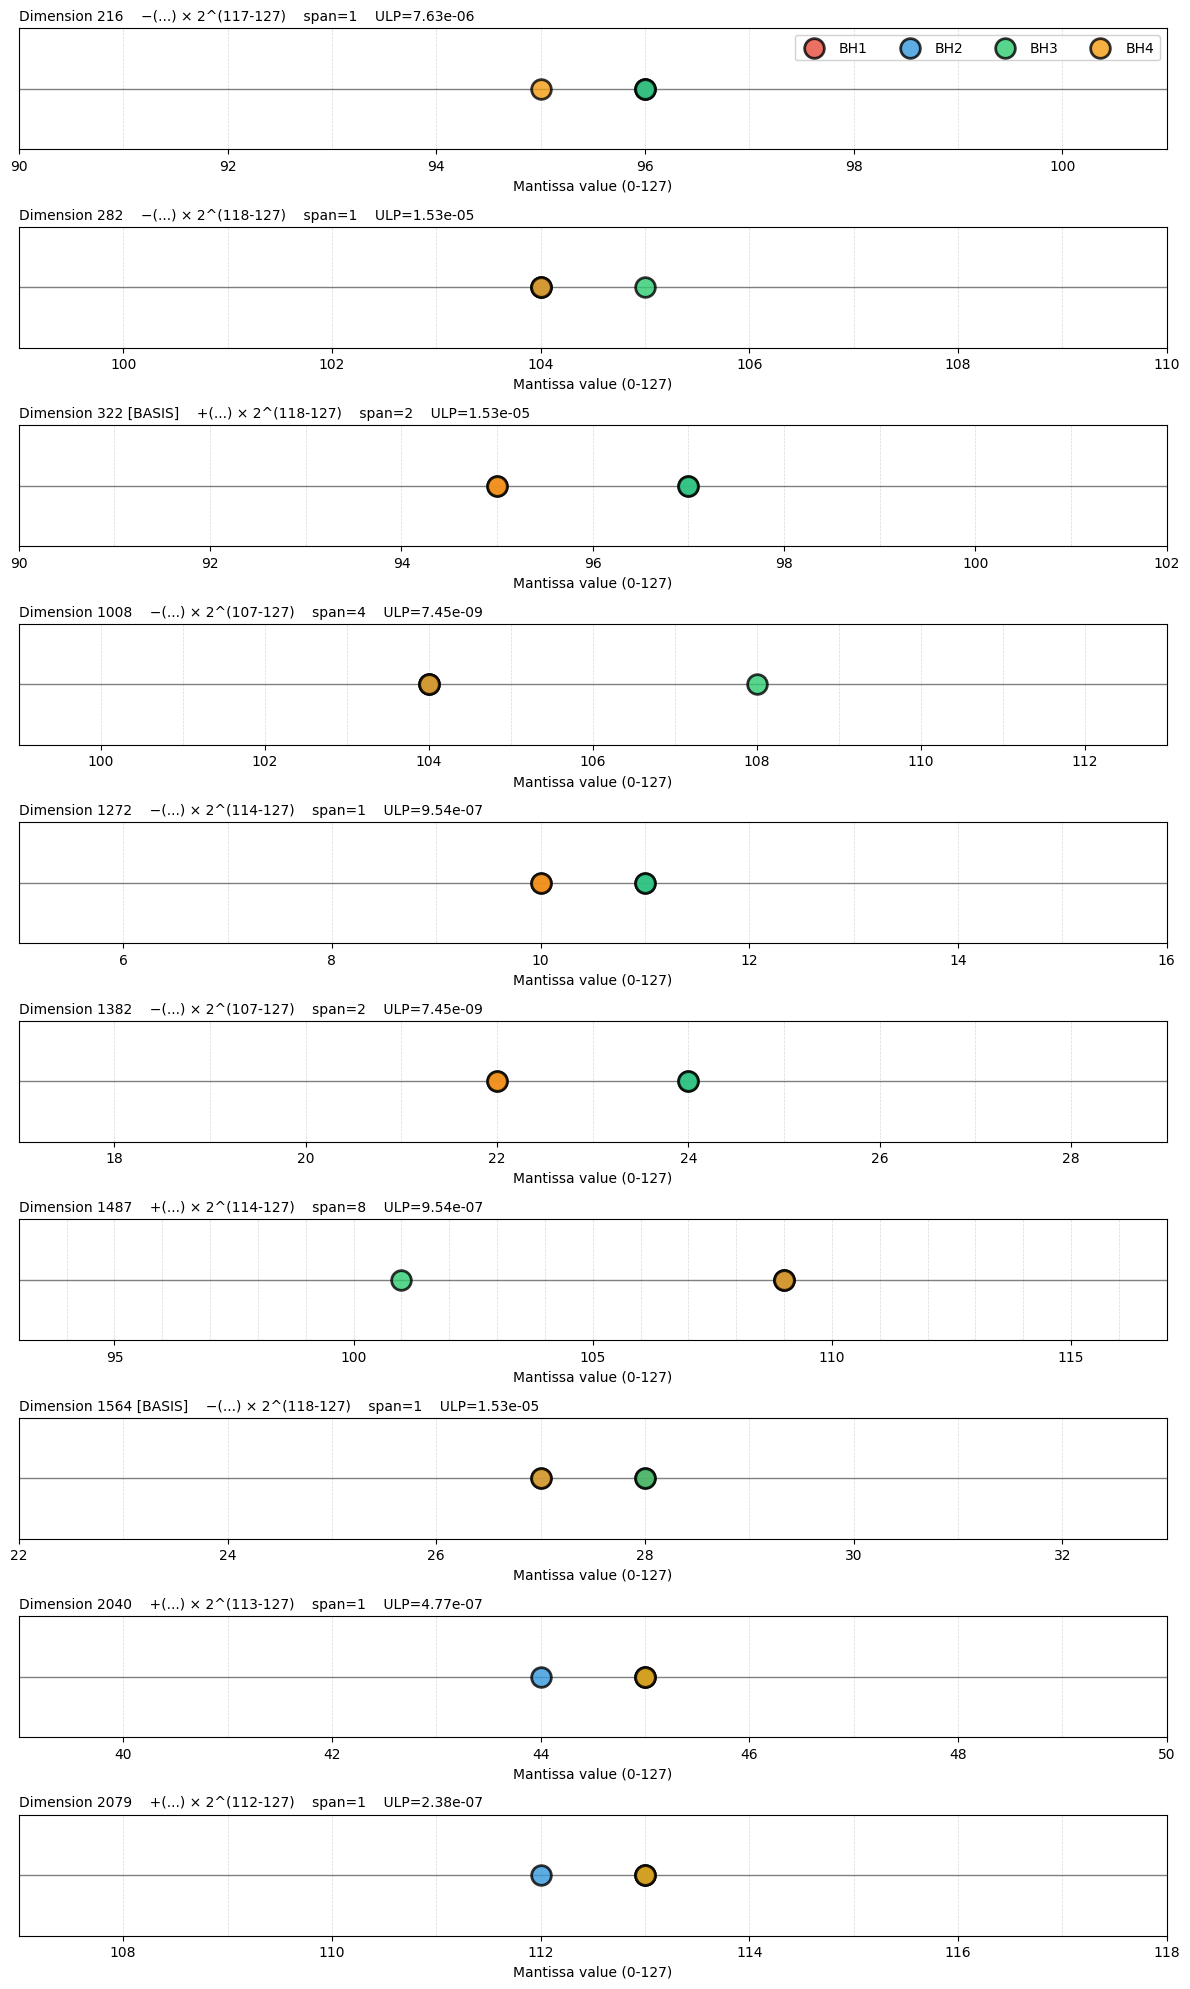

✓ Visualization complete


In [9]:
print("\nVisualizing the grid...\n")

# Create figure with one subplot per dimension
fig, axes = plt.subplots(len(DIMENSIONS_TO_ANALYZE), 1, 
                         figsize=(12, 2 * len(DIMENSIONS_TO_ANALYZE)), 
                         dpi=100)

if len(DIMENSIONS_TO_ANALYZE) == 1:
    axes = [axes]

# Color map for black holes
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']  # red, blue, green, orange
bh_labels = ['BH1', 'BH2', 'BH3', 'BH4']

for ax, data in zip(axes, grid_data):
    dim = data['dim']
    mantissas = data['mantissas']
    exponent = data['exponent']
    sign = data['sign']
    ulp = data['ulp']
    is_basis = data['is_basis']
    
    # Plot mantissa values
    for i, (mantissa, color, label) in enumerate(zip(mantissas, colors, bh_labels)):
        ax.scatter([mantissa], [0], s=200, c=color, edgecolors='black', 
                   linewidths=2, alpha=0.8, zorder=10, label=label)
    
    # Set x-axis to show mantissa range
    min_mant = min(mantissas)
    max_mant = max(mantissas)
    span = max_mant - min_mant
    
    # Add some padding
    padding = max(5, span)
    ax.set_xlim(min_mant - padding, max_mant + padding)
    
    # Add grid lines at integer mantissa values
    for m in range(int(min_mant - padding), int(max_mant + padding + 1)):
        ax.axvline(m, color='gray', linewidth=0.5, linestyle='--', alpha=0.3, zorder=1)
    
    # Styling
    ax.set_yticks([])
    ax.set_xlabel('Mantissa value (0-127)')
    ax.axhline(0, color='black', linewidth=1, alpha=0.5, zorder=5)
    
    # Title with dimension, exponent, span, and ULP
    sign_str = "−" if sign == 1 else "+"
    basis_marker = " [BASIS]" if is_basis else ""
    title = f"Dimension {dim}{basis_marker}    {sign_str}(...) × 2^({exponent}-127)    span={span}    ULP={ulp:.2e}"
    ax.set_title(title, fontsize=10, loc='left')
    
    # Add legend only on first subplot
    if data == grid_data[0]:
        ax.legend(loc='upper right', ncol=4, framealpha=0.9)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Summary: The Shape of the Grid

In [10]:
print("\n" + "=" * 80)
print("SUMMARY: THE GRID STRUCTURE")
print("=" * 80)
print()

print("The 4 black holes occupy a discrete 10D lattice:")
print()

# Count dimensions by span
spans = [max(d['mantissas']) - min(d['mantissas']) for d in grid_data]
span_counts = {}
for span in spans:
    span_counts[span] = span_counts.get(span, 0) + 1

print("Mantissa span distribution:")
for span in sorted(span_counts.keys()):
    count = span_counts[span]
    dims = [d['dim'] for d in grid_data if (max(d['mantissas']) - min(d['mantissas'])) == span]
    print(f"  Span {span}: {count} dimensions {dims}")

print()
print("Geometric interpretation:")
total_span = sum(spans)
avg_span = total_span / len(spans)
print(f"  Total extent (sum of spans): {total_span} mantissa steps")
print(f"  Average extent per dimension: {avg_span:.1f} mantissa steps")
print(f"  Active dimensions: {len(DIMENSIONS_TO_ANALYZE)}")
print(f"  Frozen dimensions: {2560 - len(DIMENSIONS_TO_ANALYZE)}")

print()
print("The black holes form an irregular lattice in 10D mantissa-space,")
print("embedded in 2560D space with 2550 frozen dimensions.")
print()
print("=" * 80)


SUMMARY: THE GRID STRUCTURE

The 4 black holes occupy a discrete 10D lattice:

Mantissa span distribution:
  Span 1: 6 dimensions [216, 282, 1272, 1564, 2040, 2079]
  Span 2: 2 dimensions [322, 1382]
  Span 4: 1 dimensions [1008]
  Span 8: 1 dimensions [1487]

Geometric interpretation:
  Total extent (sum of spans): 22 mantissa steps
  Average extent per dimension: 2.2 mantissa steps
  Active dimensions: 10
  Frozen dimensions: 2550

The black holes form an irregular lattice in 10D mantissa-space,
embedded in 2560D space with 2550 frozen dimensions.

